<a href="https://colab.research.google.com/github/timothyngtinhang/fastbook/blob/master/tutorials/W0D1_PythonWorkshop1/student/W0D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: LIF Neuron Part I

**Week 0, Day 1: Python Workshop 1**

**By Neuromatch Academy**

__Content creators:__ Marco Brigham and the [CCNSS](https://www.ccnss.org/) team

__Content reviewers:__ Michael Waskom, Karolina Stosio, Spiros Chavlis

__Production editors:__ Ella Batty, Spiros Chavlis


---
# Tutorial objectives

During NMA, you will be using code to learn computational neuroscience in an interactive (and hopefully fun) way. This tutorial and the next are to help you get up to speed on Python before the course, so that during the course you can focus on the computational neuroscience concepts.


In this notebook, we'll practice basic operations with Python variables, control flow, plotting, and take a sneak peek at `np.array`, the workhorse of scientific computation in Python.

Each new concept in Python will unlock a different aspect of our implementation of a **Leaky Integrate-and-Fire (LIF)** neuron. And as if it couldn't get any better, we'll visualize the evolution of its membrane potential in time, and extract its statistical properties!


---
# Setup

Please execute the cell(s) below to initialize the notebook environment.

In [1]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch-precourse",
            "user_key": "8zxfvwxw",
        },
    ).render()


feedback_prefix = "W0D1_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

---
# Section 1: Python basics & the LIF model

In [4]:
# @title Video 1: Python basics & the LIF model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Bwm6rjRpVw8'), ('Bilibili', 'BV1vV41167T1')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [5]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Python_basics_and_the_LIF_model_Video")

## Section 1.1: The LIF Model

A *membrane equation* and a *reset condition* define our *leaky-integrate-and-fire (LIF)* neuron:

\begin{align}
\tau_m\,\frac{d}{dt}\,V(t) &= E_{L} - V(t) + R\,I(t) &\text{if }\quad V(t) \leq V_{th} \\ \\
V(t) &= V_{reset} &\text{otherwise}
\end{align}

<br>
where $V(t)$ is the membrane potential, $\tau_m$ is the membrane time constant, $E_{L}$ is the leak potential, $R$ is the membrane resistance, $I(t)$ is the synaptic input current, $V_{th}$ is the firing threshold, and $V_{reset}$ is the reset voltage. We can also write $V_m$ for membrane potential, which is more convenient for plot labels.

The membrane equation describes the time evolution of membrane potential $V(t)$ in response to synaptic input and leaking of charge across the cell membrane. This is an *ordinary differential equation (ODE)*, a concept we will learn more about in future days.

**Note that, in this tutorial the neuron model will not implement a spiking mechanism.**

## Section 1.2: Comments in code

In [6]:
# @title Video 2: Nano recap of comments and strings
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'UP8rD2AwceM'), ('Bilibili', 'BV1fg4y1v7P3')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [7]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_comments_and_strings_Video")

### Coding Exercise 1: Defining parameters
We start by defining and initializing the main simulation variables for our LIF neuron.

In the code cell below, please modify the code to print the simulation parameters.

In [12]:
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere

print(t_max, dt, tau, el, vr, vth, r, i_mean)

0.15 0.001 0.02 -0.06 -0.07 -0.05 100000000.0 2.5e-10


**SAMPLE OUTPUT**

```
0.15 0.001 0.02 -0.06 -0.07 -0.05 100000000.0 2.5e-10
```

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_4adeccd3.py)



In [13]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Defining_Parameters_Ecercise")

We needed to remove the #'s at the start of each line - otherwise the code is read as comments and not actually run. Sometimes when you're writing code, you may want to "comment out" sections of code for debugging purposes. Note that we tried to use descriptive variable names, in this case that correspond to the math notation we use. We also used comments to denote units within the code - this makes it much easier to understand!

## Section 1.3: Math operations



### Coding Exercise 2: Simulating an input current
![synaptic input](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/synaptic_input.png)

We need to simulate the synaptic input $I(t)$ that goes into our model neuron. We will start with a sinusoidal model to simulate this input (visualized above), using the equation:

\begin{equation}
I(t)=I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t\right)\right)
\end{equation}

where $I_{mean}$ is the mean current input and $t$ is the time.

In the next cell, you will compute the values of synaptic input $I(t)$ between $t=0$ and $t=0.009$ with step $\Delta t=0.001$.

<br>

**New coding concepts**:

- We use a **for loop** in the code below. We will dive deeper into for loops later, but essentially for loops allow us to run the same code block multiple times. In this case, we loop over steps so the variable *step* equals something new each time. We use the following syntax:

  ```python
  for step in range(10):
  ```

  This means that `step` will take each integer value between 0 and 9.

- You can use `np.pi` as the value of $\pi$ and `np.sin(x)` to get the sine of x. These come from a package called numpy, which we'll learn about later.

<br>

$^{\dagger}$Generally, the `range` python function returns a sequence of numbers, starting from 0 (by default), and increments by 1 (by default), and stops before a specified number.

Syntax:

```python
range(start, stop, step)
```

Parameters:

- *start*: Optional. An integer number specifying at which position to start. Default is 0
- *stop*: Required. An integer number specifying at which position to stop (not included).
- *step*: Optional. An integer number specifying the incrementation. Default is 1

In [14]:
# Loop for 10 steps, variable 'step' takes values from 0 to 9
for step in range(10):

  # Compute value of t
  t = step * dt

  # Compute value of i at this time step
  i = i_mean * (1 + np.sin(2*np.pi / 0.01 * t))

  # Print value of i
  print(i)

2.5e-10
3.969463130731183e-10
4.877641290737885e-10
4.877641290737885e-10
3.9694631307311837e-10
2.5000000000000007e-10
1.0305368692688166e-10
1.2235870926211617e-11
1.223587092621159e-11
1.0305368692688186e-10


**SAMPLE OUTPUT**

```
2.5e-10
3.969463130731183e-10
4.877641290737885e-10
4.877641290737885e-10
3.9694631307311837e-10
2.5000000000000007e-10
1.0305368692688176e-10
1.2235870926211617e-11
1.223587092621159e-11
1.0305368692688186e-10
```

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_0833b67f.py)



In [15]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simulating_an_Input_Current_Ecercise")

## Section 1.4: Print formatting

Print formatting is handy for displaying simulation parameters in a clean and organized form. Python 3.6 introduced the new string formatting [f-strings](https://www.python.org/dev/peps/pep-0498). Since we are dealing with type `float` variables, we use `f'{x:.3f}'` for formatting `x` to three decimal points, and `f'{x:.4e}'` for four decimal points but in exponential notation.
```
x = 3.14159265e-1
print(f'{x:.3f}')
--> 0.314

print(f'{x:.4e}')
--> 3.1416e-01
```

### Coding Exercise 3: Printing pretty numbers


Repeat the loop from the previous exercise and print the `t` values with three decimal points, and synaptic input $I(t)$ with four decimal points in exponential notation.



In [21]:
# Initialize step_end
step_end = 10

# Loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Compute value of i at this time step
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

  # Print value of t and i
  print(f'{t:.3f} {i:.4e}')


0.000 2.5000e-10
0.001 3.9695e-10
0.002 4.8776e-10
0.003 4.8776e-10
0.004 3.9695e-10
0.005 2.5000e-10
0.006 1.0305e-10
0.007 1.2236e-11
0.008 1.2236e-11
0.009 1.0305e-10


**SAMPLE OUTPUT**

```
0.000 2.5000e-10
0.001 3.9695e-10
0.002 4.8776e-10
0.003 4.8776e-10
0.004 3.9695e-10
0.005 2.5000e-10
0.006 1.0305e-10
0.007 1.2236e-11
0.008 1.2236e-11
0.009 1.0305e-10
```

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_b2d23280.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Printing_Pretty_Numbers_Ecercise")

---
# Section 2: For loops & discrete time integration




In [ ]:
# @title Video 3: For loops & discrete time integration
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JkxgotYwu4Q'), ('Bilibili', 'BV1nt4y1Q7Z5')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_For_Loops_and_Discrete_time_integration_Video")

## Section 2.1: For Loops

A for loop implements the indented code block multiple times (with the variable being looped over equaling something new each time). The following three formulations are all equivalent and loop for three steps:
```
for step in [0, 1, 2]:
  print(step)

for step in range(3):
  print(step)

start = 0
end = 3
stepsize = 1

for step in range(start, end, stepsize):
  print(step)
```


## Section 2.2: Discrete time integration with spikes


In [ ]:
# @title Video 4: Nano recap of discrete time integration
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'kyCbeR28AYQ'), ('Bilibili', 'BV1mt4y1Q7Ls')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_Discrete_time_integration_Video")

In the next exercises, we will simulate the evolution of the membrane equation in discrete time steps, with a sufficiently small $\Delta t$.

We start by writing the time derivative $d/dt\,V(t)$ in the membrane equation without taking the limit $\Delta t \to 0$:

\begin{equation}
\tau_m\,\frac{V\left(t+\Delta t\right)-V\left(t\right)}{\Delta t} = E_{L} - V(t) + R\,I(t) \qquad\qquad (1)
\end{equation}

The value of membrane potential $V\left(t+\Delta t\right)$ can be expressed in terms of its previous value $V(t)$ by simple algebraic manipulation. For *small enough* values of $\Delta t$, this provides a good approximation of the continuous-time integration.

This operation is an integration since we obtain a sequence $\{V(t), V(t+\Delta t), V(t+2\Delta t),...\}$ starting from the ODE. Notice how the ODE describes the evolution of $\frac{d}{dt}\,V(t)$, the derivative of $V(t)$, but not directly the evolution of $V(t)$. For the evolution of $V(t)$ we need to integrate the ODE, and in this tutorial, we will do a discrete-time integration using the Euler method. See [Numerical methods for ordinary differential equations](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations) for additional details.

### Coding Exercise 4: Simulating membrane potential
Compute the values of $V(t)$ between $t=0$ and $t=0.01$ with step $\Delta t=0.001$ and $V(0)=E_L$.


We need to reorganize the Eq. (1) to isolate $V\left( t+\Delta t \right)$ on the left side, and express it as function of $V(t)$ and the other terms:

\begin{equation}
V(t + \Delta t) =  V(t) + \frac{\Delta t}{\tau_m}\left( E_L -V(t) + R I(t) \right)
\end{equation}

In [24]:
#################################################
## TODO for students: fill out compute v code ##
# Fill out code and comment or remove the next line
# raise NotImplementedError("Student exercise: You need to fill out code to compute v")
#################################################


# t_max = 150e-3   # second
# dt = 1e-3        # second
# tau = 20e-3      # second
# el = -60e-3      # milivolt
# vr = -70e-3      # milivolt
# vth = -50e-3     # milivolt
# r = 100e6        # ohm
# i_mean = 25e-11  # ampere

# Initialize step_end and v0
step_end = 10
v = el

# Loop for step_end steps
for step in range(step_end):
  # Compute value of t
  t = step * dt

  # Compute value of i at this time step
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

  # Compute v
  v = v + dt / tau * (el - v + r * i)

  # Print value of t and v
  print(f"{t:.3f} {v:.4e}")

0.000 -5.8750e-02
0.001 -5.6828e-02
0.002 -5.4548e-02
0.003 -5.2381e-02
0.004 -5.0778e-02
0.005 -4.9989e-02
0.006 -4.9974e-02
0.007 -5.0414e-02
0.008 -5.0832e-02
0.009 -5.0775e-02


**SAMPLE OUTPUT**

```
0.000 -5.8750e-02
0.001 -5.6828e-02
0.002 -5.4548e-02
0.003 -5.2381e-02
0.004 -5.0778e-02
0.005 -4.9989e-02
0.006 -4.9974e-02
0.007 -5.0414e-02
0.008 -5.0832e-02
0.009 -5.0775e-02
```

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_6477ecbb.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simulating_membrane_potential_Exercise")

---
# Section 3: Plotting

In [26]:
# @title Video 5: Intro to plotting
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'RmdPBHn9kjk'), ('Bilibili', 'BV1MC4y1h77q')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Intro_to_Plotting_Video")

In [27]:
# @title Video 6: Nano recap of plotting
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'BOh8CsuTFkY'), ('Bilibili', 'BV1BA411e7eH')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_Plotting_Video")

## Coding Exercise 5: Plotting current

In this exercise, we will plot the values of $I(t)$ between $t=0$ and $t=0.024$.

You will first need to set the title and axis labels of the plot. Label these descriptively!  You will then need to fill out the code to actually create the plot.


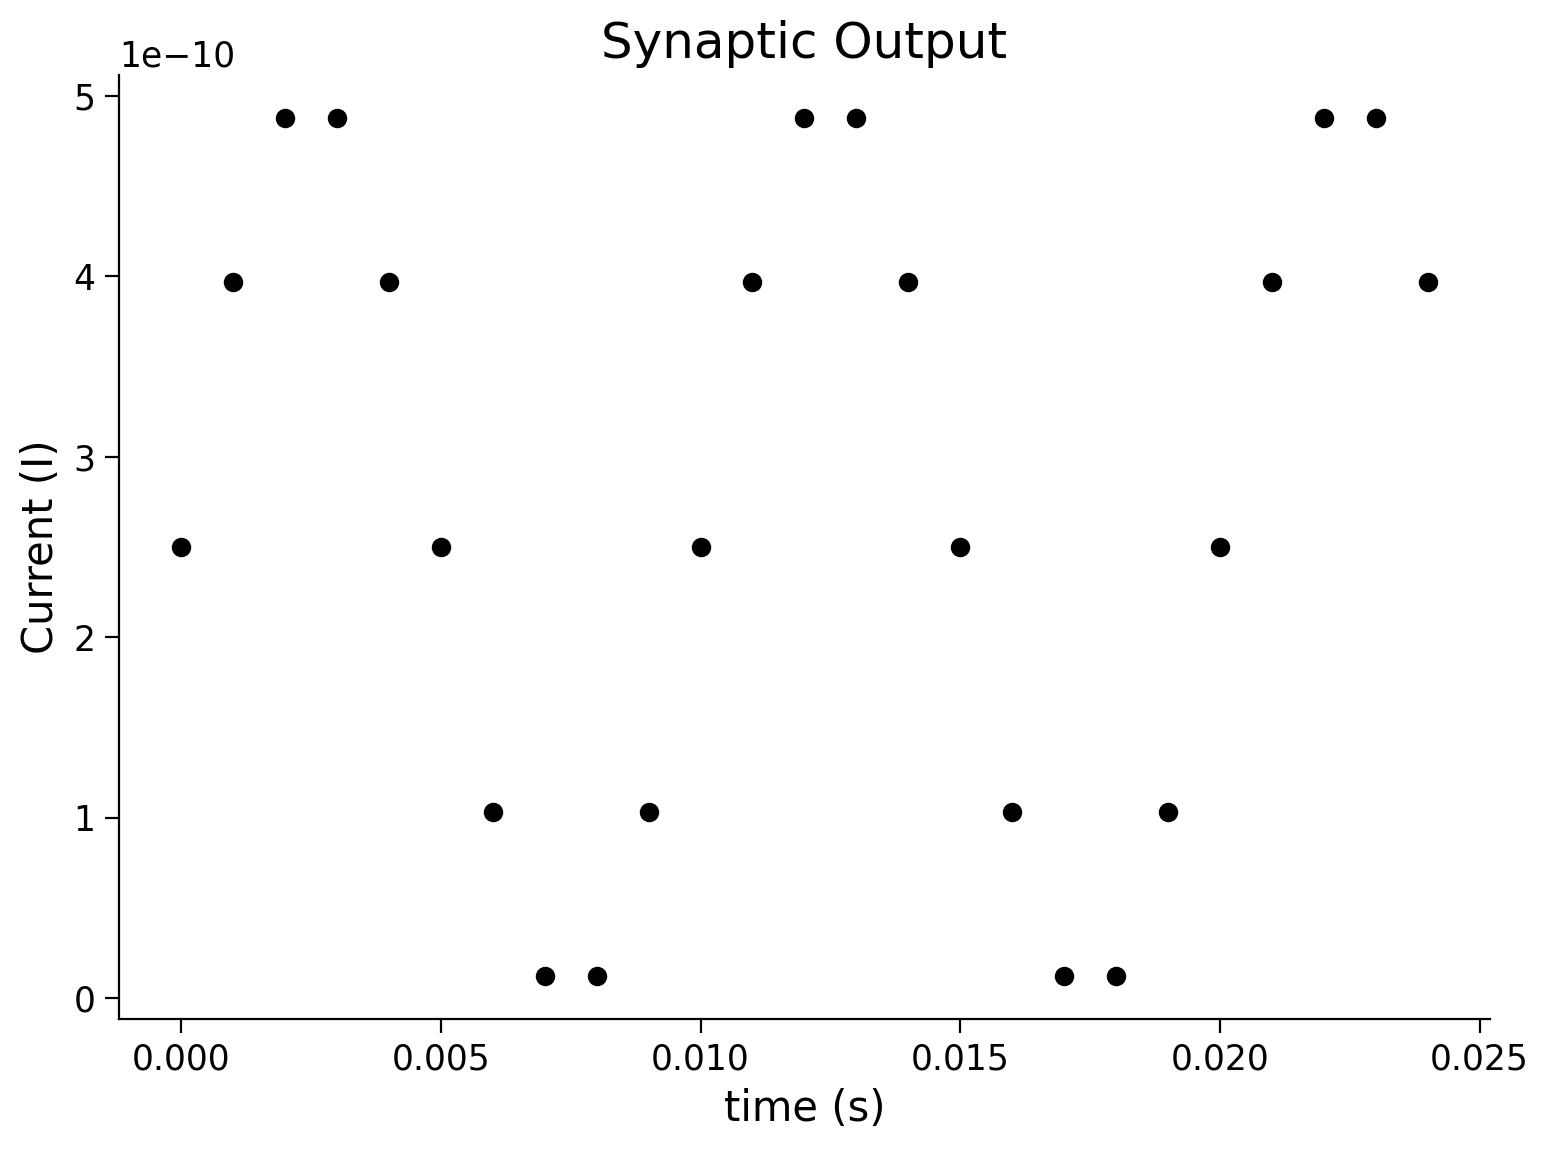

In [30]:
#################################################
## TODO for students: fill out the figure initialization and plotting code below ##
# Fill out code and comment or remove the next line
# raise NotImplementedError("Student exercise: You need to fill out current figure code")
#################################################

# Initialize step_end
step_end = 25

# Initialize the figure
plt.figure()
plt.title("Synaptic Output")
plt.xlabel("time (s)")
plt.ylabel("Current (I)")

# Loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Compute value of i at this time step
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

  # Plot i (use 'ko' to get small black dots (short for color='k' and marker = 'o'))
  plt.plot(t, i, 'ko', label='dot')

# Display the plot
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_c15c544f.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=578.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_c15c544f_0.png>



We are plotting the curent input at discrete steps only. If we plotted the current continuously, it would resemble the blue line below.

![synaptic input discrete](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/synaptic_input_discrete.png)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Plotting_current_Exercise")

## Coding Exercise 6: Plotting membrane potential
Plot the values of $V(t)$ between $t=0$ and $t=t_{max}$. We can compute the number of steps required to get to $t=t_{max}$ given $\Delta t$ as `int(t_max/dt)` where `int` gets the nearest integer.


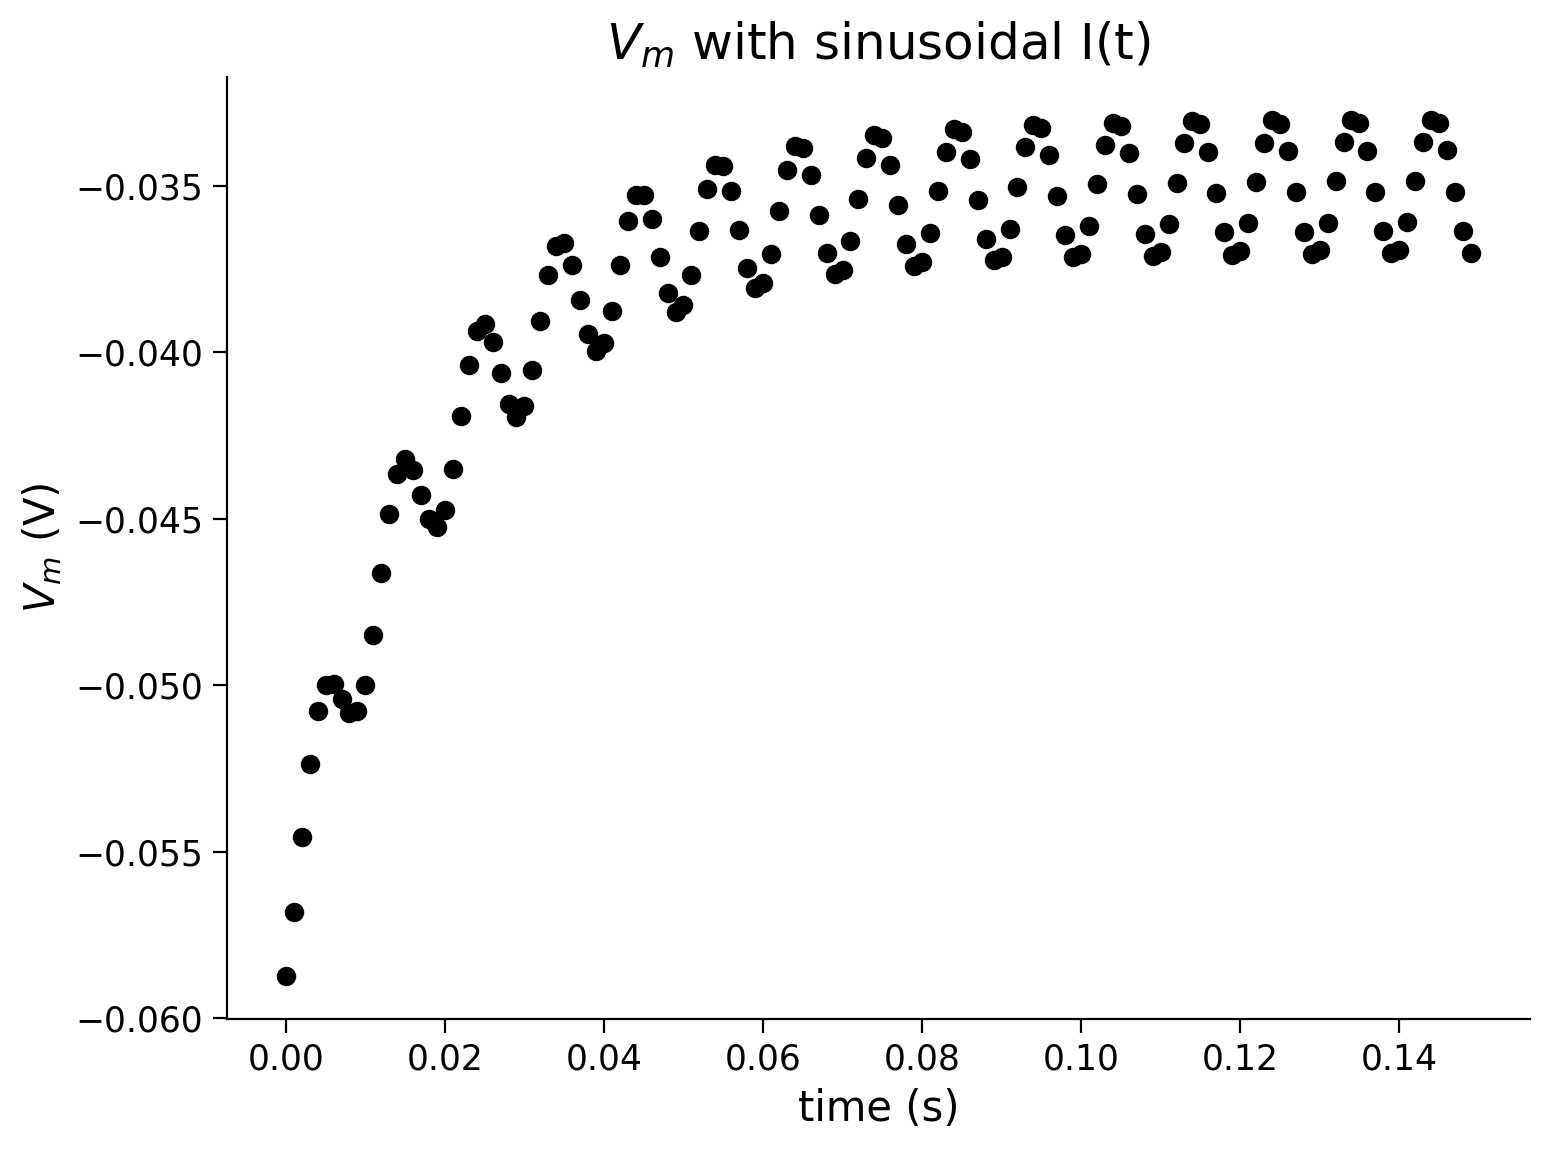

In [33]:
#################################################
## TODO for students: fill out the figure initialization and plotting code below ##
# Fill out code and comment or remove the next line
# raise NotImplementedError("Student exercise: You need to fill out membrane potential figure code")
#################################################

# Initialize step_end
step_end = int(t_max / dt)

# Initialize v0
v = el

# Initialize the figure
plt.figure()
plt.title('$V_m$ with sinusoidal I(t)')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)');

# Loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Compute value of i at this time step
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))

  # Compute v
  v = v + dt/tau * (el - v + r*i)

  # Plot v (using 'k.' to get even smaller markers)
  plt.plot(t, v, 'ko', label='dot')

# Display plot
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_70f05c19.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_70f05c19_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Plotting_membrane_potential_Exercise")

---
# Section 4: Random synaptic input

From the perspective of neurons, synaptic input is random (or stochastic). We'll improve the synaptic input model by introducing random input current with statistical properties similar to the previous exercise:

\begin{equation}
I(t) = I_{mean}\left(1+0.1\sqrt{\frac{t_{max}}{\Delta t}}\,\xi(t)\right)\qquad\text{with }\xi(t)\sim \mathcal{U}(-1,1)
\end{equation}

where $\mathcal{U}(-1,1)$ is the [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)) with support $x\in[-1,1]$.

We can approximate randomness in code using a pseudo random number generator. The function `np.random.seed()` initializes the RNG. If we initialize this with a number (e.x. `np.random.seed(2)`), we will get the same random number draws each time we run the code. Basically, we are making the random number generation replicable. We do this here so you can get a figure that exactly matches the solution. The function `np.random.random()` generates samples from the uniform distribution between `0` and `1`.

## Coding Exercise 7: Adding randomness

Plot the values of $V(t)$ between $t=0$ and $t=t_{max}-\Delta t$ with random input $I(t)$.


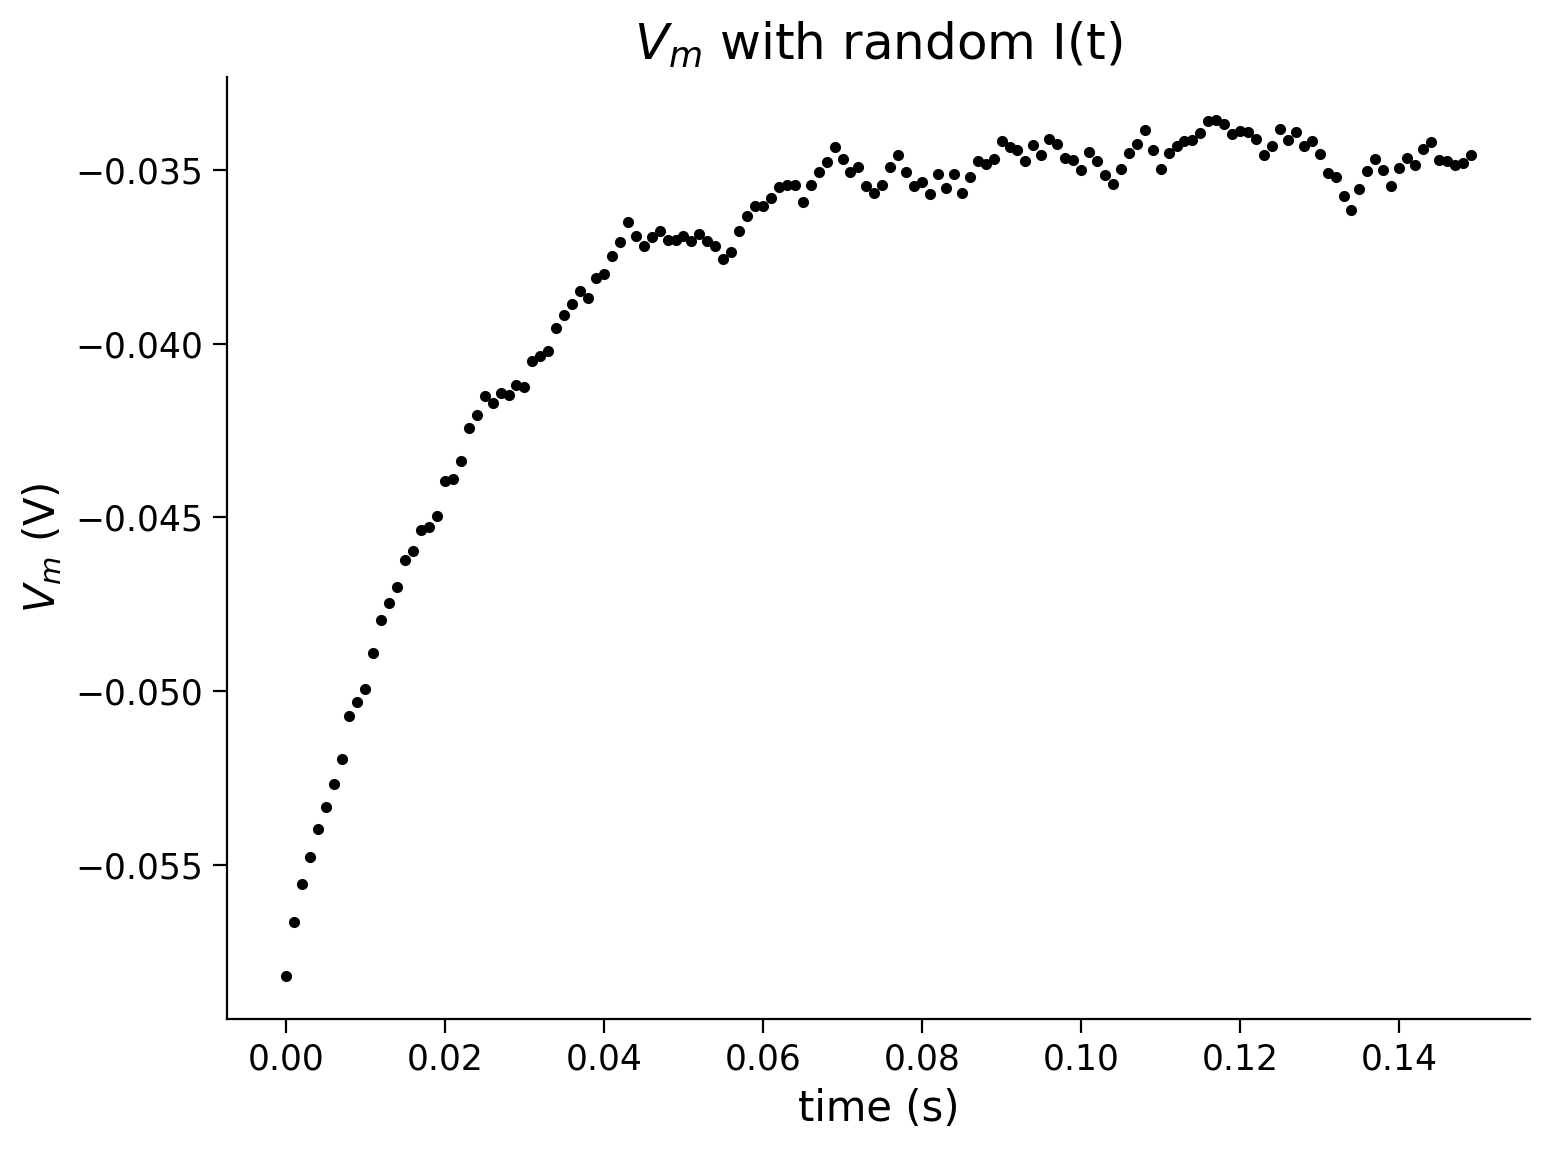

In [37]:
#################################################
## TODO for students: fill out code to get random input ##
# Fill out code and comment or remove the next line
# raise NotImplementedError("Student exercise: You need to fill out random input code")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end and v
step_end = int(t_max / dt)
v = el

# Initialize the figure
plt.figure()
plt.title('$V_m$ with random I(t)')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

# loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Get random number in correct range of -1 to 1 (will need to adjust output of np.random.random)
  random_num = np.random.random() * 2 - 1

  # Compute value of i at this time step
  i = i_mean * (1 + 0.1*(tau / dt)**0.5 * random_num)

  # Compute v
  v = v + dt/tau * (el - v + r*i)

  # Plot v (using 'k.' to get even smaller markers)
  plt.plot(t, v, 'k.')


# Display plot
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_413e2a3c.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_413e2a3c_0.png>



Random synaptic input $I(t)$ results in random time course for $V(t)$.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Adding_randomness_Exercise")

---
# Section 5: Lists & ensemble statistics


In [38]:
# @title Video 7: Lists & ensemble statistics
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'A2foheo44h4'), ('Bilibili', 'BV1ff4y197Hx')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Lists_&_ensemble_statistics_Video")

In [ ]:
# @title Video 8: Nano recap of ensemble statistics & lists
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '4nIAS2oPEFI'), ('Bilibili', 'BV1UZ4y1u7sV')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_ensemble_statistics_&_lists_Video")

Multiple runs of the previous exercise may give the impression of periodic regularity in the evolution of $V(t)$. We'll collect the sample mean over $N=50$ realizations of $V(t)$  with random input to test such a hypothesis. The sample mean, sample variance and sample autocovariance at times $\left\{t, s\right\}\in[0,t_{max}]$, and for $N$ realizations $V_n(t)$ are given by:

\begin{align}
\\
\left\langle V(t)\right\rangle &= \frac{1}{N}\sum_{n=1}^N V_n(t) & & \text{sample mean}\\
\left\langle (V(t)-\left\langle V(t)\right\rangle)^2\right\rangle &= \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)^2 & & \text{sample variance} \\
\left\langle \left(V(t)-\left\langle V(t)\right\rangle\right)\left(V(s)-\left\langle V(s)\right\rangle\right)\right\rangle
&= \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)\left(V_n(s)-\left\langle V(s)\right\rangle\right) & & \text{sample autocovariance}
\end{align}

## Coding Exercise 8: Storing simulations in lists
Plot multiple simulations ($N=50$) of $V(t)$ by storing in a list the voltage of each neuron at time $t$.

Keep in mind that the plotting command `plt.plot(x, y)` requires `x` to have the same number of elements as `y`.

Mathematical symbols such as $\alpha$ and $\beta$ are specified as `$\alpha$` and `$\beta$` in [TeX markup](https://en.wikipedia.org/wiki/TeX). See additional details in [Writing mathematical expressions](https://matplotlib.org/3.2.2/tutorials/text/mathtext.html) in Matplotlib.


In [ ]:
#################################################
## TODO for students: fill out code to store v in list ##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to store v in list")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end and n
step_end = int(t_max / dt)
n = 50

# Intiatialize the list v_n with 50 values of membrane leak potential el
v_n = ...

with plt.xkcd():
  # Initialize the figure
  plt.figure()
  plt.title('Multiple realizations of $V_m$')
  plt.xlabel('time (s)')
  plt.ylabel('$V_m$ (V)')

  # Loop for step_end steps
  for step in range(step_end):

    # Compute value of t
    t = step * dt

    # Loop for n simulations
    for j in range(0, n):

      # Compute value of i at this time step
      i = i_mean * (1 + 0.1 * (t_max/dt)**(0.5) * (2* np.random.random() - 1))

      # Compute value of v for this simulation
      v_n[j] = ...

    # Plot all simulations (use alpha = 0.1 to make each marker slightly transparent)
    plt.plot(...)

  # Display plot
  plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_04e56444.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_04e56444_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Storing_simulations_in_lists_Exercise")

## Coding Exercise 9: Plotting sample mean

Add the sample mean $\left\langle V(t)\right\rangle=\frac{1}{N}\sum_{n=1}^N V_n(t)$ to the plot.


In [ ]:
#################################################
## TODO for students: fill out code to plot sample mean ##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to plot the sample mean")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end and n
step_end = int(t_max / dt)
n = 50

# Intiatialize the list v_n with 50 values of membrane leak potential el
v_n = [el] * n

# Initialize the figure
plt.figure()
plt.title('Multiple realizations of $V_m$')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

# Loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Loop for n simulations
  for j in range(0, n):

    # Compute value of i at this time step
    i = i_mean * (1 + 0.1 * (t_max/dt)**(0.5) * (2* np.random.random() - 1))

    # Compute value of v for this simulation
    v_n[j] = v_n[j] + (dt / tau) * (el - v_n[j] + r*i)

  # Compute sample mean by summing list of v_n using sum, and dividing by n
  v_mean = ...

  # Plot simulations
  plt.plot(n*[t], v_n, 'k.', alpha=0.1)

  # Plot sample mean using alpha=0.8 and'C0.' for blue
  plt.plot(...)

# Display plot
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_684b683f.py)

*Example output:*

<img alt='Solution hint' align='left' width=775.0 height=575.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_684b683f_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Plotting_sample_mean_Exercise")

## Coding Exercise 10: Plotting sample standard deviation

Add the sample standard deviation $\sigma(t)\equiv\sqrt{\text{Var}\left(t\right)}$ to the plot, with sample variance $\text{Var}(t) = \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)^2$.

Use a list comprehension to collect the sample variance `v_var`. Here's an example to initialize a list with squares of `0` to `9`:
```
squares = [x**2 for x in range(10)]
print(squares)
--> [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
```

Think: Why are we plotting $\sigma(t)$ rather than the $\text{Var}(t)$? What are the units of each and the units of $\left\langle V(t)\right\rangle$?


In [ ]:
#################################################
## TODO for students: fill out code to plot sample standard deviation ##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to plot the sample standard deviation")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end and n
step_end = int(t_max / dt)
n = 50

# Intiatialize the list v_n with 50 values of membrane leak potential el
v_n = [el] * n

# Initialize the figure
plt.figure()
plt.title('Multiple realizations of $V_m$')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

# Loop for step_end steps
for step in range(step_end):

  # Compute value of t
  t = step * dt

  # Loop for n simulations
  for j in range(0, n):

    # Compute value of i at this time step
    i = i_mean * (1 + 0.1 * (t_max/dt)**(0.5) * (2* np.random.random() - 1))

    # Compute value of v for this simulation
    v_n[j] = v_n[j] + (dt / tau) * (el - v_n[j] + r*i)

  # Compute sample mean
  v_mean = sum(v_n) / n

  # Initialize a list `v_var_n` with the contribution of each V_n(t) to
  # Var(t) with a list comprehension over values of v_n
  v_var_n = ...

  # Compute sample variance v_var by summing the values of v_var_n with sum and dividing by n-1
  v_var = ...

  # Compute the standard deviation v_std with the function np.sqrt
  v_std = ...

  # Plot simulations
  plt.plot(n*[t], v_n, 'k.', alpha=0.1)

  # Plot sample mean using alpha=0.8 and'C0.' for blue
  plt.plot(t, v_mean, 'C0.', alpha=0.8, markersize=10)

  # Plot mean + standard deviation with alpha=0.8 and argument 'C7.'
  plt.plot(...)

  # Plot mean - standard deviation with alpha=0.8 and argument 'C7.'
  plt.plot(...)


# Display plot
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_c05a930d.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_c05a930d_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Plotting_sample_standard_deviation_Exercise")

---
# Section 6: Using NumPy


In [ ]:
# @title Video 9: Using NumPy
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'OIzSQvMbe2k'), ('Bilibili', 'BV1wa4y1a7Xq')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Using_NumPy_Video")

![NumPy package](https://github.com/NeuromatchAcademy/precourse/blob/main/tutorials/W0D1_PythonWorkshop1/static/numpy_logo_small.png?raw=True)

<br>

The next set of exercises introduces `np.array`, the workhorse from the scientific computation package [NumPy](https://numpy.org). Numpy arrays the default for numerical data storage and computation and will separate computing steps from plotting.

We updated plots inside the main loop in the previous exercises and stored intermediate results in lists for plotting them. The purpose was to simplify earlier exercises as much as possible. However, there are very few scenarios where this technique is necessary, and you should avoid it in the future. Using numpy arrays will significantly simplify our coding narrative by computing inside the main loop and plotting afterward.

Lists are much more natural for storing data for other purposes than computation. For example, lists are handy for storing numerical indexes and text.

In [ ]:
# @title Video 10: Nano recap of using NumPy
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'ewyHKKa2_OU'), ('Bilibili', 'BV1of4y197jo')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_using_NumPy_Video")

## Coding Exercise 11: Rewriting with NumPy

Rewrite the single neuron plot with random input from _Exercise 7_ with numpy arrays.

The time range, voltage values, and synaptic current are initialized or pre-computed as numpy arrays before numerical integration. We use `np.linspace` to initialize a numpy array `t_range` with `num=step_end=150` values from `0` to `t_max`
We use `np.ones` to initialize a numpy array `v` with `step_end + 1` leak potential values `el`. You will pre-compute `step_end` synaptic current values in numpy array `i` with `np.random.random(step_end)` for `step_end` random numbers. Since `v[0]=el`, we should iterate for `step_end` steps but skip `step=0`.

In [ ]:
#################################################
## TODO for students: fill out code to rewrite simulation in numpy##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to rewrite simulation in numpy")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, v
step_end = int(t_max / dt) - 1
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)
v = el * np.ones(step_end)

# Simulate current over time
i = ...

# Loop for step_end steps
for step in range(1, step_end):

  # Compute v as function of i
  v[step] = ...


# Plot membrane potential
plt.figure()
plt.title('$V_m$ with random I(t)')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

plt.plot(t_range, v, 'k.')
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_66c71ad3.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_66c71ad3_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Rewriting_with_NumPy_Exercise")

## Coding Exercise 12: Using enumerate & indexing
Let's practice using `enumerate` to iterate over the indexes and values of the synaptic current array `i`. We want to get the step and the value of i at that step `i_step`


In [ ]:
#################################################
## TODO for students: fill out code to rewrite simulation in numpy##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to rewrite simulation in numpy")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, t_range, v
step_end = int(t_max / dt) - 1
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)
v = el * np.ones(step_end)

# Simulate current over time
i = i_mean * (1 + 0.1 * (t_max/dt) ** (0.5) * (2 * np.random.random(step_end) - 1))

# Loop for step_end values of i using enumerate
for step, i_step in enumerate(i):

  # Skip first iteration
  if step==0:
    continue

  # Compute v as function of i using i_step
  v[step] = ...

# Plot figure
plt.figure()
plt.title('$V_m$ with random I(t)')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

plt.plot(t_range, v, 'k')
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_40b5ed28.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_40b5ed28_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Using_enumerate_and_indexing_Exercise")

---
# Section 7: Aggregation

In [ ]:
# @title Video 11: Aggregation
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'E6FyhSsO4Vg'), ('Bilibili', 'BV1Uk4y1q76p')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Aggregation_Video")

In [ ]:
# @title Video 12: Nano recap of aggregation
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '1ME-0rJXLFg'), ('Bilibili', 'BV1vA411e7w4')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nano_recap_of_aggregation_Video")

## Coding Exercise 13: Using 2D arrays

Plot multiple realizations ($N=50$) of $V(t)$ by storing the voltage of each neuron at time $t$ in a numpy array.

We first initialize a numpy array `v_n` of shape `(n, step_end)` with membrane leak potential values `el`. We pre-compute synaptic current values in numpy array `i` of shape `(n, step_end)`. After computing v, we plot results with a single plot command, by providing `v_n.T` to the plot function. `v_n.T` is the transposed version of `v_n` (with rows and columns swapped).

In [ ]:
#################################################
## TODO for students: fill out code to use 2d arrays ##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to rewrite code to use 2d arrays")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, n, t_range, v and i
step_end = int(t_max / dt)
n = 50
t_range = np.linspace(0, t_max, num=step_end)
v_n = el * np.ones([n, step_end])
i = ...

# Loop for step_end - 1 steps
for step in range(1, step_end):

   # Compute v_n
   v_n[:, step] = ...

# Plot figure
plt.figure()
plt.title('Multiple realizations of $V_m$')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

plt.plot(...)
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_93456241.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_93456241_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Using_2D_arrays_Exercise")

## Coding Exercise 14: Plotting sample mean and standard deviation

Add sample mean $\left\langle V(t)\right\rangle$ and standard deviation $\sigma(t)\equiv\sqrt{\text{Var}\left(t\right)}$ to the plot.

`np.mean(v_n, axis=0)` computes mean over rows, i.e. mean for each neuron

`np.mean(v_n, axis=1)` computes mean over columns (axis `1`), i.e. mean for each time step

We will use label argument in plt.plot to specify labels in each trace.  We label only the last voltage trace to avoid labeling all N of them.

In [ ]:
#################################################
## TODO for students: fill out code to compute sample mean and standard deviation ##
# Fill out code and comment or remove the next line
raise NotImplementedError("Student exercise: You need to  fill out code to compute sample mean and standard deviation")
#################################################

# Set random number generator
np.random.seed(2020)

# Initialize step_end, n, t_range, v and i
step_end = int(t_max / dt)
n = 50
t_range = np.linspace(0, t_max, num=step_end)
v_n = el * np.ones([n, step_end])
i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# Loop for step_end - 1 steps
for step in range(1, step_end):

  # Compute v_n
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r * i[:, step])

# Compute sample mean (use np.mean)
v_mean = ...

# Compute sample standard deviation (use np.std)
v_std = ...

# Plot figure
plt.figure()
plt.title('Multiple realizations of $V_m$')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

plt.plot(t_range, v_n.T, 'k', alpha=0.3)

plt.plot(t_range, v_n[-1], 'k', alpha=0.3, label='V(t)')
plt.plot(t_range, v_mean, 'C0', alpha=0.8, label='mean')
plt.plot(t_range, v_mean+v_std, 'C7', alpha=0.8)
plt.plot(t_range, v_mean-v_std, 'C7', alpha=0.8, label='mean $\pm$ std')

plt.legend()
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/precourse/tree/main/tutorials/W0D1_PythonWorkshop1/solutions/W0D1_Tutorial1_Solution_3c8e55c9.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/precourse/main/tutorials/W0D1_PythonWorkshop1/static/W0D1_Tutorial1_Solution_3c8e55c9_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Plotting_sample_mean_and_standard_deviation_Exercise")

---
# Summary


In [ ]:
# @title Video 13: Overview
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'VqAznnSAqmM'), ('Bilibili', 'BV1Fv411q7tE')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Overview_Video")